In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from itertools import permutations 

from math import ceil

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
cfier = MLPClassifier(hidden_layer_sizes=(7,), random_state = 13, solver="lbfgs", verbose=True)
data = pd.read_csv("../Data/95_percent_var_PCs.csv")

In [3]:
def split_pca_data(df, cols=("PC1","PC164"), target="target", test_pct=0.8, rng_seed=0,  ):
    train_df, test_df = train_test_split(df, train_size=test_pct, random_state=23)
    test_lbl = test_df["target"]
    train_lbl =  train_df["target"]
    train = train_df.loc[:,cols[0]:cols[1]]
    test = test_df.loc[:,cols[0]:cols[1]]
    return train,  test, train_lbl, test_lbl

In [4]:
train_data, test_data, train_lbls, test_lbls = split_pca_data(data, rng_seed=23)

# Standardize scale to training data
scaler = StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)



# Bayesian hyperparameter searching using Hyperopt
- The python libary hyperopt has an implementation of a [Tree Parzen Estimator](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) based bayesian hyperoptimizer.

Practically speaking the fmin function attempts to optimize the hyperparameter set using the tree parzen estimator (TPE) as a surrogate function for the actual objective function (which involves cross-validating a neural network). This TPE updates its preference for certain paramater values in a bayesian fashion, based on information gained from the last set of hyperparameters chosen and the resulting loss. 

In [5]:
from hyperopt import hp, Trials, fmin, tpe, space_eval, STATUS_OK, STATUS_FAIL
from timeit import default_timer as timer
from statistics import mean


## Experimenting with various search spaces
I think it's wise to keep alpha as a uniform distribution. I'll start with normal distributions for the number now neurons in each layer and see where that takes things. 

1. Search space 1: normal distributions with large variance. 
    - layer 1: ~N(mu = 150 neurons, sigma = 65)
    - layer 2: ~N(mu = 75 neurons, sigma = 32)
    - alpha: uniform {0.1, 0.01,... 10^-7}

In [6]:
# Define the search space. Dictionaries are in key:value where the value is a probabilistic space to 
# "randomly" chose from (I believe as TPE algorithm works, it changes updates probabilistic distributions)
search_space =  hp.choice("layers", [
    {
        "type": "two_layer",
        "k": hp.quniform("2layers_k",1,7,1), # k is selecting for bias alpha, where alpha = 10^-k [0.1, 0.01, ... 10^-7]
        "l1": hp.qnormal("2layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("2layers_l2",75, 32, 1), #  mu =75, stdev=32
        "iters": hp.qnormal("2layers_max_iters", 300, 25, 1)
    },
    {
        "type": "three_layer",
        "k": hp.quniform("3layers_k",1,7,1),
        "l1": hp.qnormal("3layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("3layers_l2",75, 32, 1), # mu =75, stdev=32
        "l3": hp.qnormal("3layers_l3",40, 20, 1), # Discretized normal dist, mu =75, stdev=32
        "iters": hp.qnormal("3layers_max_iters", 300, 35, 1)
    }
])

# Define the optimization function (Costly as it implies fitting a MLP classifier via CV)
def objective(architecture):
    """ The objective function to optimize is the 5-fold cross-validation fitting of a 2 hidden layer NN classifier.
        The hyperoptimizer operates as a minimizer, so the returned loss will be the negative of the avg of 
        mean accuracy.
    """
    # Determine classifer hyperparams from architecture dictionary given
    if "l3" in architecture:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]), int(architecture["l3"]))
    else:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]))
    k = architecture["k"]
    iters = architecture["iters"]
    
    # Make a new MLP Classifier
    cfier = MLPClassifier(max_iter=iters, hidden_layer_sizes=shape, solver= "lbfgs", alpha = pow(10, -k),
                        random_state=25)
    
    # Cross Validatae
    results = cross_validate(cfier, X=train_data, y=train_lbls, cv=5, n_jobs=-1)
    # Results must contain a "loss" value for hyperopt to minimize, and the status
    results["loss"] = -1 * mean(results["test_score"])
    del results["test_score"]
    # For brevity report means
    results["fit_time"] = mean(results["fit_time"])
    results["score_time"] = mean(results["score_time"])
    results["status"] = STATUS_OK

    
    return results
    

In [7]:
# Create a trials Hyperopt Object which stores data regarding the results of our hyperparameter search
trials = Trials()

# Run the hyperparam search. We'll let the hyperopt lib suggest the tpe to use
best_performer = fmin(fn=objective, space=search_space, algo=tpe.suggest, trials=trials, max_evals=100, 
                        rstate= np.random.RandomState(29))



100%|██████████| 100/100 [00:34<00:00,  2.90trial/s, best loss: -0.6729838709677419]


## Hyperparameter optimization performance

Best performing architecture
	layers: 3
	alpha: 0.01
	Training Iterations: 295.0
	iterations: 295.0
	l1 neurons: 164.0
	l2 neurons: 101.0
	l3 neurons: 37.0


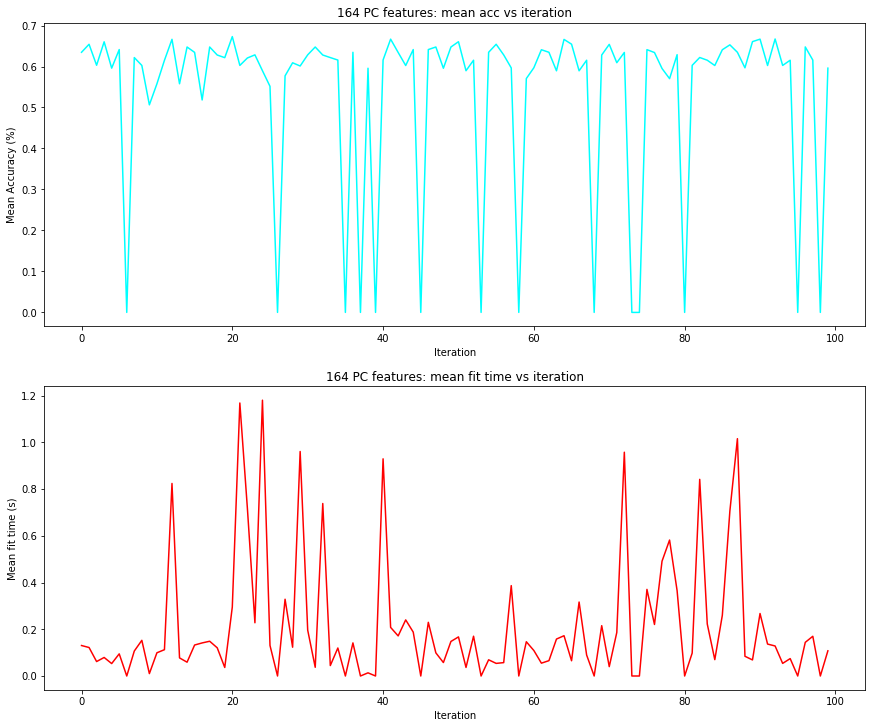

In [8]:
# Analyze Hyperopt Progress
layers = best_performer["layers"] + 2
alpha = pow(10, -1 * best_performer[f"{layers}layers_k"])
iters = best_performer[f"{layers}layers_max_iters"]
l1_neurons = best_performer[f"{layers}layers_l1"]
l2_neurons = best_performer[f"{layers}layers_l2"]

print(f"Best performing architecture")
print(f"\tlayers: {layers}")
print(f"\talpha: {alpha}")
print(f"\tTraining Iterations: {iters}")
print(f"\titerations: {iters}")
print(f"\tl1 neurons: {l1_neurons}")
print(f"\tl2 neurons: {l2_neurons}")

if 3 == layers:
    l3_neurons = best_performer[f"{layers}layers_l3"]
    print(f"\tl3 neurons: {l3_neurons}")

# Plot mean accuracy versus iteration, and train time versus iteration
mean_acc = [abs(res["loss"]) for res in trials.results]
fit_time = [abs(res["fit_time"]) for res in trials.results]

fig, axs = plt.subplots(2, 1, constrained_layout=True)
mean_acc_nafiltered = pd.Series(mean_acc).fillna(value=0) # Replace NaNs with 0's
axs[0].plot(mean_acc_nafiltered, c="cyan")
axs[0].set_title(f"164 PC features: mean acc vs iteration")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Mean Accuracy (%)")
axs[1].plot(fit_time, c="red")
axs[1].set_title(f"164 PC features: mean fit time vs iteration")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Mean fit time (s)")

fig.set_figwidth(12)
fig.set_figheight(10)

## Training and Testing Optimal Architecture Performance 

Classification Report for 164 PC feature MLP classifier
               precision    recall  f1-score   support

           0       0.44      0.52      0.48        21
           1       0.29      0.22      0.25        18

    accuracy                           0.38        39
   macro avg       0.36      0.37      0.36        39
weighted avg       0.37      0.38      0.37        39



(0, 2)

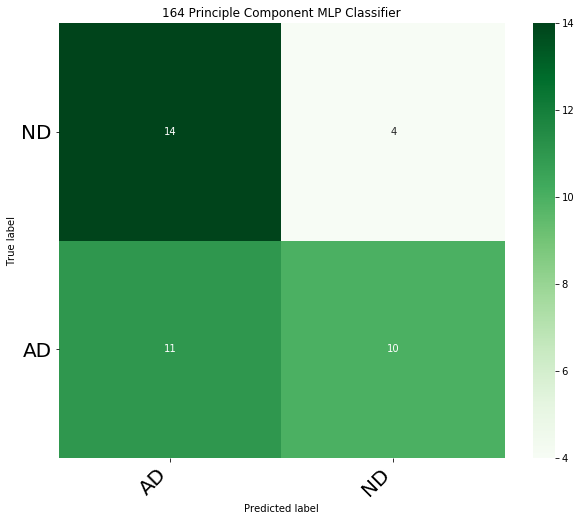

In [9]:
from print_conf_mat import *

if 3 == layers:
    shape = (3,int(l1_neurons),int(l2_neurons),int(l3_neurons))
else:
    shape = (2,int(l1_neurons),int(l2_neurons))

cfier = MLPClassifier(max_iter=iters, hidden_layer_sizes=shape, solver="lbfgs", alpha=alpha,
                      random_state=25)
cfier.fit(train_data, train_lbls)

predictions = cfier.predict(test_data)
c_mat = confusion_matrix(test_lbls, predictions)
report = classification_report(test_lbls, predictions)
print(f"Classification Report for 164 PC feature MLP classifier\n {report}")

fig = print_confusion_matrix(c_mat, ["AD", "ND"], figsize=(10,8), fontsize=20, 
                             title="164 Principle Component MLP Classifier")
# y-axis annotation alignment goofs up on some versions of matplitlib.  
# If this is the case, comment/uncomment the following line
fig.gca().set_ylim([0,2])
